# Aligning SEM and STEM images Part 2: Perspective alignment
- Load real and binary image stacks
- Apply perspective transform (*Homography*)
- Plot the relationship between greyscale values and thickness

In [1]:
import glob2
import numpy as np
import cv2
import hyperspy.api as hs

from skimage import filters, transform
from scipy import ndimage

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def thres_func(image):
    image.data = image.data > filters.threshold_li(image.data)
    return image

def Fill_ICE(image):
    image.data = ndimage.binary_fill_holes(image.data)
    return image

def Denoise_EELS(image):
    image.data = np.invert(ndimage.binary_fill_holes(np.invert(image.data)))
    return image

def man_thres_func(image, threshold):
    image.data = image.data > threshold
    return image

# Load images

In [2]:
files = glob2.glob('*.hdf5')
files

['Part 1 Binary images.hdf5', 'Part 1 real images.hdf5']

In [3]:
binary_ims, real_ims = [hs.load(f) for f in files[0:2]]

# Homography

In [4]:
'''Convert images to uint8 and normalise. Opencv very fussy.'''
real_cv = {'tld' : real_ims.split()[0].data, 'ice' : real_ims.split()[1].data, 'eels': real_ims.split()[2].data, }


binary_cv = {'tld_bin' : binary_ims.split()[0].data.astype('uint8') * 255,
             'ice_bin' : binary_ims.split()[1].data.astype('uint8') * 255,
             'eels_bin': binary_ims.split()[2].data.astype('uint8') * 255}

In [6]:
def Align_by_translation(im1, im2):
    # Define the warp model
    warp_model = cv2.MOTION_TRANSLATION

    warp_matrix = np.eye(2, 3, dtype=np.float32)

    # iterations and termination threshold
    number_of_iterations = 10000
    termination_eps = 1e-5
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the algorithm. Results stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC(im1, im2, warp_matrix, warp_model, criteria)

    # Apply the warp
    im2_aligned = cv2.warpAffine(im2, warp_matrix, (im1.shape[1], im1.shape[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return im2_aligned, warp_matrix

def Align_translation_many(im1, im2, im3):
    im2_aligned, warp_matrix = Align_by_translation(im1, im2)
    
    # Apply the warp
    im3_aligned = cv2.warpAffine(im3, warp_matrix, (im1.shape[1], im1.shape[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return im2_aligned, im3_aligned
    


def Align_by_homography(im1, im2, im1_gray, im2_gray):
    # Define the warp model
    warp_model = cv2.MOTION_HOMOGRAPHY

    warp_matrix = np.eye(3, 3, dtype=np.float32)

    # iterations and termination threshold
    number_of_iterations = 10000
    termination_eps = 1e-6
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the algorithm. Results stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC(im1_gray, im2_gray, warp_matrix, warp_model, criteria)

    # Apply the warp
    im2_aligned = cv2.warpPerspective(im2, warp_matrix, (im1.shape[1], im1.shape[0]),
                                       flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return im2_aligned

def Align_many_by_homography(im1, im2, also_warp=[]):
    '''Warps im2 to be the same shape as im1. im2 and im1 need to have the same
    contrast mechanism or be binary. Also_warp is a list of images which will be
    warped in the same way as im2.'''
    
    # Define the warp model
    warp_model = cv2.MOTION_HOMOGRAPHY

    warp_matrix = np.eye(3, 3, dtype=np.float32)

    # iterations and termination threshold
    number_of_iterations = 10000
    termination_eps = 1e-6
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the algorithm. Results stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC(im1, im2, warp_matrix, warp_model, criteria)

    # Apply the warp
    im2_aligned = cv2.warpPerspective(im2, warp_matrix, (im1.shape[1], im1.shape[0]),
                                       flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    # Apply the warp to the image list

    if len(also_warp) > 0:
        warped = {'im2' : im2_aligned}
        for i, im in enumerate(also_warp):
            im_aligned = cv2.warpPerspective(im, warp_matrix, (im1.shape[1], im1.shape[0]),
                                       flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
            warped.update({str(i) : im_aligned})
            
            return warped
        else:
            return im2_aligned


def Homography_and_plot(im1, im2, im1_gray, im2_gray):
    # Do the homography and plot the result
    im2_aligned = Align_by_homography(im1, im2, im1_gray, im2_gray)
    
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9.3, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

    titles = ['im1', 'im2_aligned', 'comparison']
    ims = [im1_gray, im2_aligned, np.add(im2_aligned, np.divide(im1_gray, 2.))]

    for i, ax in enumerate(axs.flat):
        if i < 2:
            ax.imshow(ims[i])
            ax.set_title(titles[i])
        else:
            ax.imshow(ims[i], cmap='jet')
            ax.set_title(titles[i])


    #plt.savefig('ice_alignment.png', bbox='tight')
    
    plt.show()
    
    return im2_aligned
    


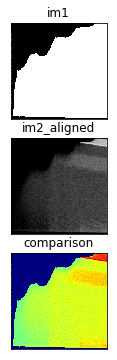

In [7]:
tld_aligned = Homography_and_plot(real_cv['eels'], real_cv['tld'], binary_cv['eels_bin'], binary_cv['tld_bin'])

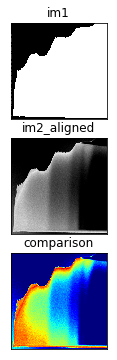

In [8]:
ice_aligned = Homography_and_plot(real_cv['eels'], real_cv['ice'], binary_cv['eels_bin'], binary_cv['ice_bin'])

If this step fails, it is likely your images are either too dissimilar or there are not enough features in region of interest.

#### Save progress

In [9]:
cv2.imwrite('tld aligned.png', tld_aligned)
cv2.imwrite('ice aligned.png', ice_aligned)

True

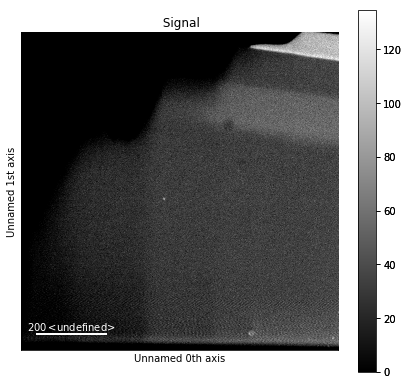

In [10]:
tld_aligned_hs = hs.signals.Signal2D(tld_aligned)
tld_aligned_hs.plot()

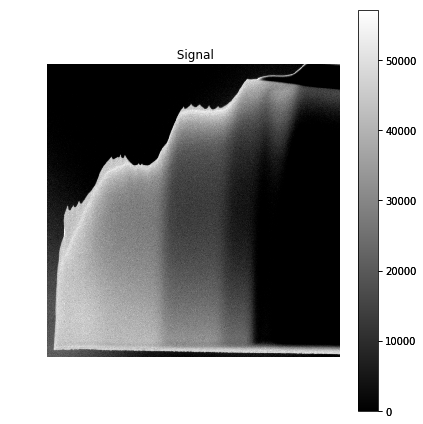

In [11]:
ice_aligned_hs = hs.signals.Signal2D(ice_aligned)
ice_aligned_hs.plot(scalebar=False, axes_off=True)

plt.savefig('ice_warped.png')

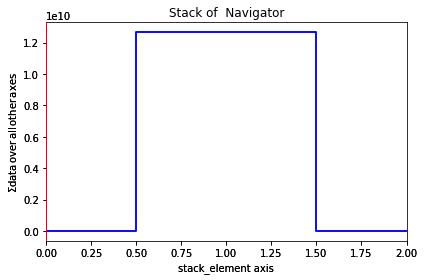

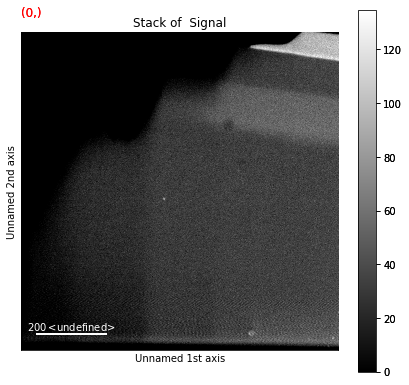

In [12]:
stack = hs.stack([tld_aligned_hs, ice_aligned_hs, real_ims.split()[2]])
stack.plot()

In [13]:
stack.save('Aligned_stack.hdf5')

---
# Make some graphs

In [15]:
import glob2
import numpy as np
import pandas as pd

import hyperspy.api as hs

import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
stack = hs.load('Aligned_stack.hdf5')

## Bin the t/$ \lambda $ values in the thickness map

In [17]:
stack.crop_image(right=650)

tld, ice, eels = stack.split()

In [18]:
ice

<Signal2D, title: , dimensions: (|650, 921)>

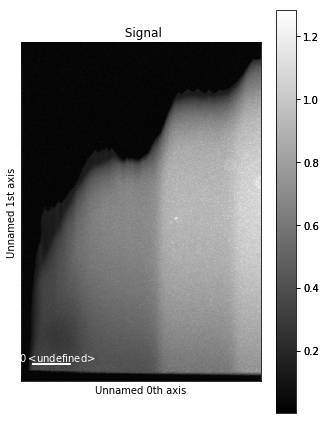

In [19]:
eels.plot()

In [20]:
np.max(eels.data)

1.2830067781291288

Choose the range of bins you want for the graph

In [23]:
bins = np.around(np.arange(0.1, 1.4, 0.05), decimals=2)

In [24]:
bins

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15,
       1.2 , 1.25, 1.3 , 1.35])

In [26]:
def columnise(image):
    '''turns an image into one series of greyscale values'''
    arr = image.data
    arr = arr.reshape(arr.shape[0] * arr.shape[1])
    return arr

In [27]:
eels_df = columnise(eels)
tld_df = columnise(tld)
ice_df = columnise(ice)

In [29]:
'''Load into a dataframe'''
df = pd.DataFrame([])
df['eels'] = eels_df
df['tld'] = tld_df
df['ice'] = ice_df
df.head(20)

,eels,tld,ice
0,0.043673,0.0,0.0
1,0.043646,0.0,90.0
2,0.043969,0.0,294.5
3,0.040514,0.0,93.5
4,0.030749,0.0,0.0
5,0.024185,0.0,0.0
6,0.025431,0.0,0.0
7,0.026981,0.0,0.0
8,0.029694,0.0,0.0
9,0.031419,0.0,0.0


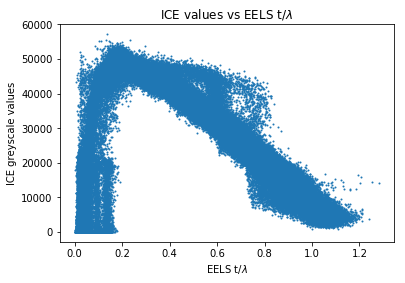

In [30]:
fig = plt.figure(figsize=[6, 4])

plt.plot(df['eels'], df['ice'], 'o', markersize=1)

plt.title('ICE values vs EELS t/$\lambda$')
plt.xlabel('EELS t/$\lambda$')
plt.ylabel('ICE greyscale values')

#plt.savefig('ICE vs EELS scatter.png', dpi=300, bbox='tight')
plt.show()

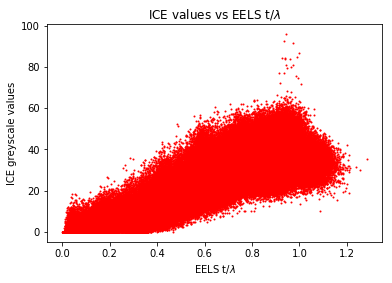

In [31]:
fig = plt.figure(figsize=[6, 4])

plt.plot(df['eels'], df['tld'], 'ro', markersize=1)

plt.title('ICE values vs EELS t/$\lambda$')
plt.xlabel('EELS t/$\lambda$')
plt.ylabel('ICE greyscale values')

#plt.savefig('ICE vs EELS scatter.png', dpi=300, bbox='tight')
plt.show()

In [32]:
df.describe()

,eels,tld,ice
count,598650.000000,598650.000000,598650.000000
mean,0.445356,16.016277,19362.436351
std,0.349990,14.679003,15952.495725
min,0.000740,0.000000,0.000000
25%,0.037150,0.000000,1304.562500
50%,0.474900,16.187500,17677.000000
75%,0.754102,29.173828,32852.000000
max,1.283007,95.796875,57164.000000


In [33]:
'''bins has the bin index the corresponding eels value belongs to'''
df['bins'] = bins[np.digitize(df['eels'], bins)]

In [34]:
grouped = df.groupby('bins')

In [35]:
'''Get stats about each detector'''

def binning_stats(detector):
    df = pd.DataFrame([])
    df['bins'] = [name for name, group in grouped]
    df['mean'] = [group[detector].mean() for name, group in grouped]
    df['std'] = [group[detector].std() for name, group in grouped]
    return df

df_ice_graph = binning_stats('ice')
df_tld_graph = binning_stats('tld')

add nm thickness column

In [36]:
df_ice_graph['thickness nm'] = df_ice_graph['bins'] * 142.0

In [37]:
df_ice_graph

,bins,mean,std,thickness nm
0,0.10,2589.247742,6295.146528,14.2
1,0.15,38608.336525,13519.111220,21.3
2,0.20,46065.763053,6905.299062,28.4
3,0.25,47556.383610,1883.929473,35.5
4,0.30,45819.185792,1599.541297,42.6
5,0.35,44475.291279,1472.269762,49.7
6,0.40,43057.218053,1759.362086,56.8
7,0.45,40957.031133,1792.568521,63.9
8,0.50,38609.110821,1914.531364,71.0
9,0.55,36135.306310,2085.397725,78.1


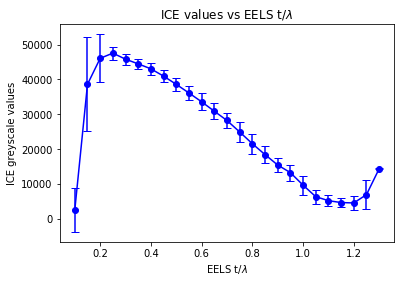

In [38]:
fig = plt.figure(figsize=[6, 4])

plt.errorbar(df_ice_graph['bins'], df_ice_graph['mean'], yerr=df_ice_graph['std'], color='b', fmt='-o', capsize=4)

plt.title('ICE values vs EELS t/$\lambda$')
plt.xlabel('EELS t/$\lambda$')
plt.ylabel('ICE greyscale values')

#plt.savefig('ICE vs EELS.png', dpi=300, bbox='tight')
plt.show()

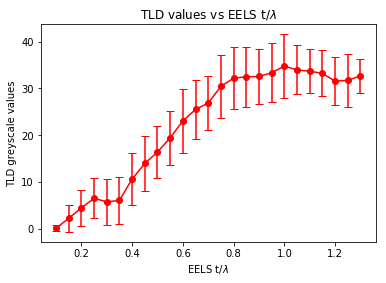

In [39]:
fig = plt.figure(figsize=[6, 4])

plt.errorbar(df_tld_graph['bins'], df_tld_graph['mean'], yerr=df_tld_graph['std'], color='r', fmt='-o', capsize=4)

plt.title('TLD values vs EELS t/$\lambda$')
plt.xlabel('EELS t/$\lambda$')
plt.ylabel('TLD greyscale values')

#plt.savefig('TLD vs EELS.png', dpi=300, bbox='tight')
plt.show()

Looks like the tld alignment did not go very well

## Map the errors
- EELS map -> bin
- convert to a false TLD image
- subtract TLD image from false image to map errors

In [42]:
fake_image = np.digitize(eels.data, bins)

In [44]:
fake_tld = df_tld_graph['mean'].values[fake_image]
fake_ice = df_ice_graph['mean'].values[fake_image]

In [45]:
error_ice = np.abs(ice.data - fake_ice)
error_tld = np.abs(tld.data - fake_tld)

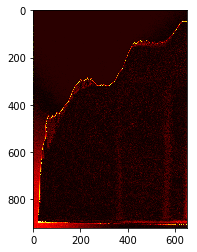

In [47]:
plt.imshow(error_ice, cmap='hot')
#plt.savefig('ice_error_map.png')

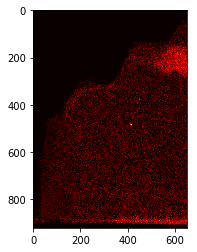

In [48]:
plt.imshow(error_tld, cmap='hot')
#plt.savefig('tld_error_map.png')